In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
stations = base.classes.station
measurement = base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
from sqlalchemy import create_engine, text, inspect, func
import datetime as dt
import pandas as pd
import numpy as np

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

2016-08-23


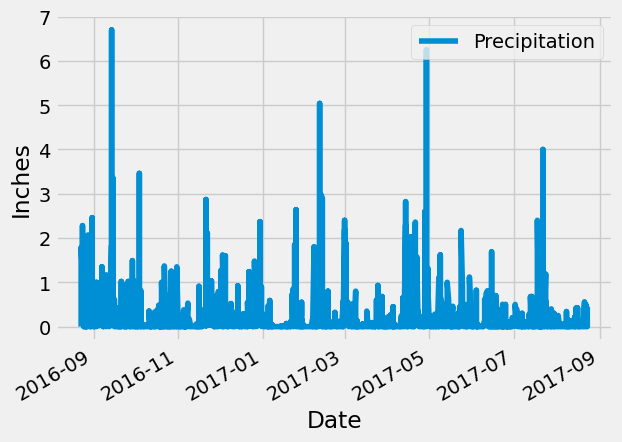

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_from_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_from_date)

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).\
        filter(measurement.date <= '2017-08-23').\
        filter(measurement.date >= '2016-08-23') # In real life, shouldn't this be '2016-08-24'?
        
# Save the query results as a Pandas DataFrame.
list = []
for row in query:
    # print(row)
    list.append(row)
# print(list)
df = pd.DataFrame(list)
df

# Clean the data
df = df.fillna(value=np.nan)
df = df.dropna()
#df

# Sort the dataframe by date
df.sort_values('date',ascending=True)

# Change date from Object to Date
df['date'] = pd.to_datetime(df['date'])

# Change name of columns
df = df.rename(columns={'prcp':'Precipitation','date':'Date'})

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='line',x='Date',y='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.savefig("Line_Chart.png")

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df[['Precipitation']].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Review columns in 'station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number of stations in the dataset
sel = [measurement.id,stations.station, stations.name, measurement.date, measurement.prcp, measurement.tobs]
station_count = session.query(*sel).filter(stations.station == measurement.station).all()
station_count
session.query(func.count(stations.station)).all()

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
counting_stations = session.query(stations.station,func.count(measurement.station)).group_by(measurement.station).\
    filter(stations.station == measurement.station).all()
counting_stations

# List the stations and their counts in descending order. 
# I used https://www.geeksforgeeks.org/sort-in-python/ to figure this out
counting_stations.sort(key=lambda x: x[1],reverse=True)
counting_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = session.query(func.min(measurement.tobs),func.max(measurement.tobs),\
    func.avg(measurement.tobs)).group_by(measurement.station).\
filter(measurement.station == stations.station,measurement.station == 'USC00519281').all()
active_station

[(54.0, 85.0, 71.66378066378067)]

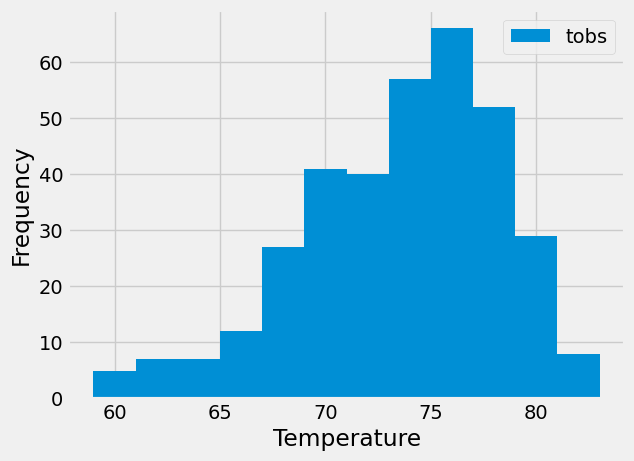

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.tobs,measurement.date).filter(measurement.date > '2016-08-23').\
    filter(measurement.date < '2017-08-23').filter(measurement.station == 'USC00519281').all()
df_1 = pd.DataFrame(histogram)
del df_1['date']
df_1

df_1.plot(kind='hist',bins=12) # 12 bins for 12 months
plt.xlabel('Temperature')
plt.savefig("Histogram.png")

# Close Session

In [20]:
# Close Session
session.close()